## QCamp Training Session
# Advanced Simulation

* Christopher J. Wood
* IBM TJ Watson Research Center, Yorktown Heights, NY, USA
* February 26, 2019

## How do we simulate NISQ devices using classical computers? (really?)

### Outline

1. Ideal quantum circuits
1. Ideal simulations with Qiskit Aer
1. Noisy quantum circuits
1. Noisy simulations with Qiskit Aer
1. Noise model examples

In [1]:
# Import the basics
import numpy as np

import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools import visualization as qplt

# Ideal Quantum Circuits

The ideal circuit based model of quantum computation consists of three pieces:
1. **States:** A *complex statevector* $|\psi\rangle$ satisfying $|\langle\psi|\psi\rangle|^2=1$
1. **Gates:** A *unitary* matrix $U$ satisfying $U^\dagger U = U U^\dagger = \mathbb{1}$.
1. **Measurements:** A *projective-valued measure (PVM)* $\{\Pi_j\}$ s.t. $p_j = |\langle \psi |\Pi_j|\psi\rangle|^2$

## Ideal Quantum States

Quantum states my be expressed as a complex vector with respect to the computation basis:

Eg for a single qubit: $|\psi\rangle = \alpha |0\rangle + \beta |1\rangle = [\alpha, \beta]$

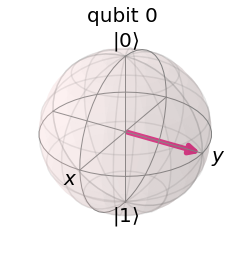

In [2]:
psi = np.array([1, 1j]) / np.sqrt(2)

qplt.plot_bloch_multivector(psi)

### How do we store a quantum state (classically)?

* Storing a quantum state requies exponential classical resources

* A general quantum statevector is $2^n$ complex floating point numbers

* $n$-qubits = $16 * 2^n$ bytes of memory

To put that in perfective:

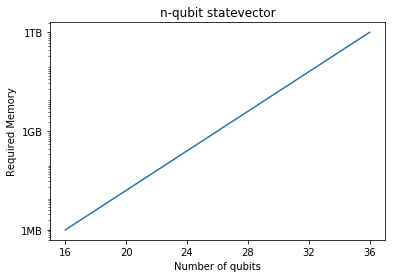

In [3]:
nqubits = [16,20,24,28,32,36]
plt.semilogy(nqubits, [1, 16, 256, 4096, 65536, 1048576])
plt.title('n-qubit statevector')
plt.xlabel('Number of qubits')
plt.ylabel('Required Memory')
plt.xticks(nqubits)
plt.yticks((1, 2 ** 10, 2 ** 20), ('1MB', '1GB', '1TB'))
plt.show()

## Ideal Quantum Gates

Ideal quantum gates are operations that map statevectors to statevectors:

$ |\psi_{i+1}\rangle = U_i |\psi_i\rangle $

These operations may be represented by *unitary matrices*.

* A matrix $U$ is unitary if and only if $U^\dagger U = U^\dagger U = \mathbb{1}$

### How do we apply unitaries in simulation?

* Full specifying an n-qubit unitary matrix requires $16 * 4^n$ complex floating point numbers

* Scaling is twice that of a statevector ($n$-qubit unitary same memory as $2n$-qubit vector)

Generally for simulation we never store the full unitary: *A quantum circuit is a decomposition of a unitary into smaller (typically 1 and 2-qubit) operations.*


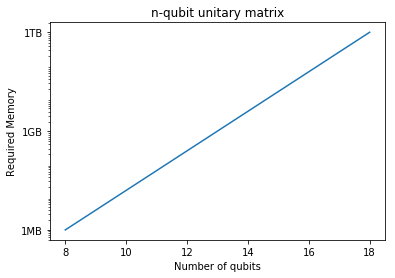

In [4]:
nqubits = [8, 10, 12, 14, 16, 18]
plt.semilogy(nqubits, [1, 16, 256, 4096, 65536, 1048576])
plt.title('n-qubit unitary matrix')
plt.xlabel('Number of qubits')
plt.ylabel('Required Memory')
plt.xticks(nqubits)
plt.yticks((1, 2 ** 10, 2 ** 20), ('1MB', '1GB', '1TB'))
plt.show()

## Ideal Measurement

* In simulation we can direct access to the wavefunction, however in experiment we can only perform measurements to extract information.

* An ideal measurement is a non-unitary operation which causes the wavefunction to *collapse*

* We will consider measurement in the computational ($Z$) basis:

If we measure a state $|\psi\rangle = \alpha_0 |0\rangle + \alpha_1 |1\rangle$

For a single measurement:
* We will observe outcome "0" with probability $p_0 = |\alpha_0|^2$, 
* After observing "0" the system will have collapsed to the state $|0\rangle$.
* Similarly outcome "1" will be observed with probability $p_1 = |\alpha_1|^2$, leaving the system in state $|1\rangle$.

# Ideal Simulations with Qiskit Aer

* Qiskit Aer is a local simulation provider for Qiskit.
* We will briefly show how to do ideal simulations with Qiskit-Aer.
* These are taken from the Aer Provider tutorial in `qiskit-tutorials`.

## Qiskit Aer simulator backends

 Qiskit Aer currently includes three simulator backends
 
* `QasmSimulator`: Simulates experiments (returns counts)
* `StatevectorSimulator`: Simulates an ideal shot of an experiment (returns statevector)
* `UnitarySimulator`: Simulates an ideal circuit (return circuit unitary)

These backends are found in the `Aer` provider with the names `qasm_simulstor`, `statevector_simulator` and `unitary_simulator` respectively

In [5]:
from qiskit import Aer
import qiskit.providers.aer as aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

## QasmSimulator

* Designed to mimic an actual device. 
* Executes `QuantumCircuit` for $N$ shots
* Returns count dictionary containing $N$ final vlaues of `ClassicalRegisters` in the circuit.
* The circuit may contain *gates*, *measure*, *reset*, *conditionals*

### Example: prepare and measure a Bell-state

* Circuit prepares a 2-qubit Bell-state $|\psi\rangle = \frac{1}{2}(|0,0\rangle + |1,1 \rangle)$
* Measures both qubits

In [6]:
# Construct quantum circuit
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.measure(qr, cr)

# Plot the circuit
print(circ.draw())

         ┌───┐        ┌─┐
qr_0: |0>┤ H ├──■─────┤M├
         └───┘┌─┴─┐┌─┐└╥┘
qr_1: |0>─────┤ X ├┤M├─╫─
              └───┘└╥┘ ║ 
 cr_0: 0 ═══════════╬══╩═
                    ║    
 cr_1: 0 ═══════════╩════
                         


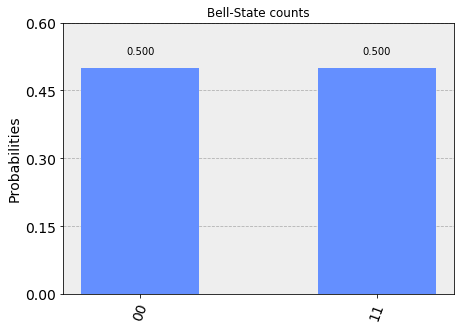

In [7]:
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = qiskit.execute(circ, simulator).result()
counts = result.get_counts(circ)
qplt.plot_histogram(counts, title='Bell-State counts')

### Returning measurements outcomes for each shot

* `QasmSimulator` also supports returning a list of outcomes for each shot. 
* Enabled by setting the keyword argument `memory=True` in `compile` or `execute`

In [8]:
# Execute and get memory
result = qiskit.execute(circ, simulator, shots=10, memory=True).result()
memory = result.get_memory(circ)
print(memory)

['00', '11', '11', '11', '11', '00', '11', '11', '00', '00']


### Starting simulation with a custom initial state

* The default initial state for `QasmSimulator` is $|\psi_0\rangle = |0^{\otimes n}\rangle$.
* `QasmSimulator` allows setting a custom initial statevector for the simulation. 
* Done using `backend_options={"initial_statevector": psi_0}` in `QasmSimulator.run` or `qiskit.execute`.

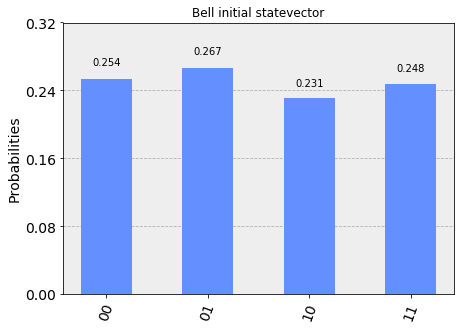

In [9]:
# Set the initial state
opts = {"initial_statevector": np.array([1, 0, 0, 1] / np.sqrt(2))}

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = qiskit.execute(circ, simulator, backend_options=opts).result()
counts = result.get_counts(circ)
qplt.plot_histogram(counts, title="Bell initial statevector")

### Requirements for initial statevector

* $|\psi_0\rangle$ must be valid quantum state: $|\langle\psi_0|\psi_0\rangle|=1$.
* If not an error will be raised. 
* The same $\psi_0\rangle$ will be used for *all* circuits in Qobj.
* If it is wrong size for number of qubits will raise an error


## Statevector Simulator

* Simulates a single-shot of a `QuantumCircuit` and returns the final quantum statevector.
* The circuit may contain *gates*, and also *measure*, *reset*, and *conditional* operations.
* If measure/reset operations are in the circuit:
  * The final state will be a *conditional state* for the outcome of those operations.
  * The measurement outcome (counts) will also be returned (with $N=1$ shots).
  
* A custom initial statevector $|\psi_0\rangle$ can be used (same as for `QasmSimulator`)

### Example: Bell state preparation

In [10]:
# Construct quantum circuit without measure
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])

# Plot the circuit
print(circ.draw())

         ┌───┐     
qr_0: |0>┤ H ├──■──
         └───┘┌─┴─┐
qr_1: |0>─────┤ X ├
              └───┘


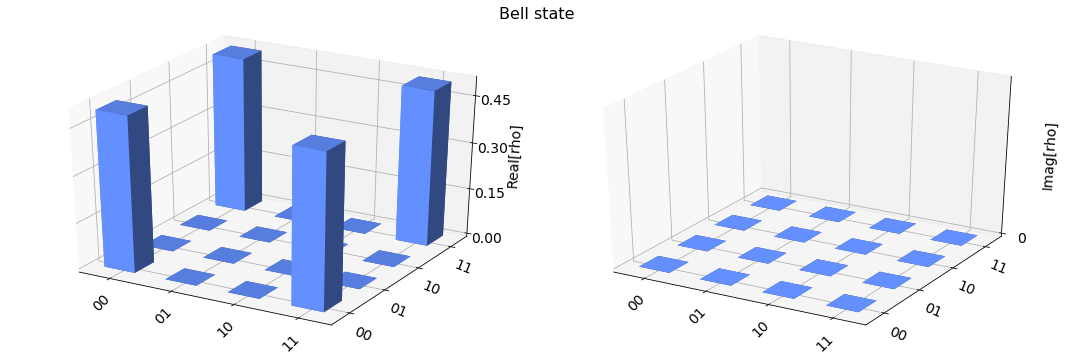

In [11]:
# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = qiskit.execute(circ, simulator).result()
statevector = result.get_statevector(circ)
qplt.plot_state_city(statevector, title='Bell state')

### Example: Bell state preparation *with measurement*

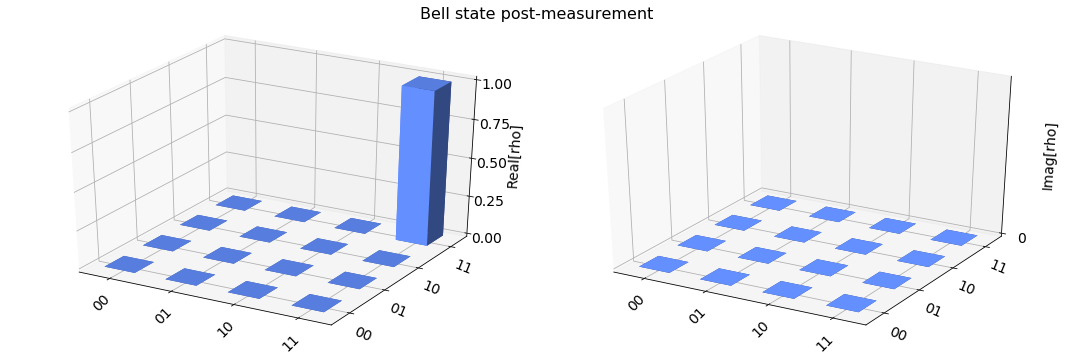

In [12]:
# Construct quantum circuit with measure
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.measure(qr, cr)

# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = qiskit.execute(circ, simulator).result()
statevector = result.get_statevector(circ)
qplt.plot_state_city(statevector, title='Bell state post-measurement')

## Unitary Simulator

* Constructs the full $n$-qubit unitary matrix for a `QuantumCircuit`.
* Done by applying each gate matrix to an initial identity matrix. 
* Circuit may only contain *gates*

### Example: Bell-state preparation circuit

In [13]:
# Construct an empty quantum circuit
qr = QuantumRegister(2)
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])

# Select the UnitarySimulator from the Aer provider
simulator = Aer.get_backend('unitary_simulator')

# Execute and get counts
result = qiskit.execute(circ, simulator).result()
unitary = result.get_unitary(circ)
print("Final Unitary:")
print(unitary)

Final Unitary:
[[ 0.70710678+0.j  0.70710678+0.j  0.00000000+0.j  0.00000000+0.j]
 [ 0.00000000+0.j  0.00000000+0.j  0.70710678+0.j -0.70710678+0.j]
 [ 0.00000000+0.j  0.00000000+0.j  0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j  0.00000000+0.j  0.00000000+0.j]]


### Custom initial unitary

* Instead of the identity matrix, a custom initial unitary can be used
* `backend_options={"initial_unitary": U0}`

### Requirements for initial unitary

* $U_0$ must be unitary ($U_0^\dagger U_0 = \mathbb{1}$).
* The same $U_0$ will be used for *all* circuits in Qobj.
* If these are violated an error will be raised

# Noisy Quantum Circuits

A noisy quantum circuit is described using formalism of *Open Quantum Systems*. For the circuit model noisy quantum computation consists of three pieces:

1. **States:** A density matrix $\rho$, satisfying $\rho \ge 0$, $Tr[\rho]=1$.
1. **Gates:** A *completely-positive trace-preserving* (CPTP) map $\cal{E}$.
1. **Measurement:** A *positive operator valued measure* (POVM) $\{E_j\}$ s.t. $p_j = Tr[E_j\rho]$

## Noisy Quantum States

* The density matrix $\rho$ can be thought of our *average knowledge* about a state averaged over many experiments.

### Example: Noisy initialization

* We have a device that is supposed to generate a single-qubit state $|0\rangle$.
* 10% of the time it generates the state $|1\rangle$ instead.
* We describe the *average output* of this noisy process as a state:

$$\rho = \frac{9}{10} * |0\rangle\langle0| + \frac{1}{10} * |1\rangle\langle1|$$

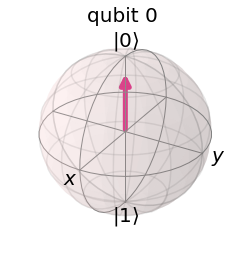

In [14]:
rho = 0.9 * np.array([[1, 0], [0, 0]]) + 0.1 * np.array([[0, 0,], [0, 1]])
qplt.plot_bloch_multivector(rho)

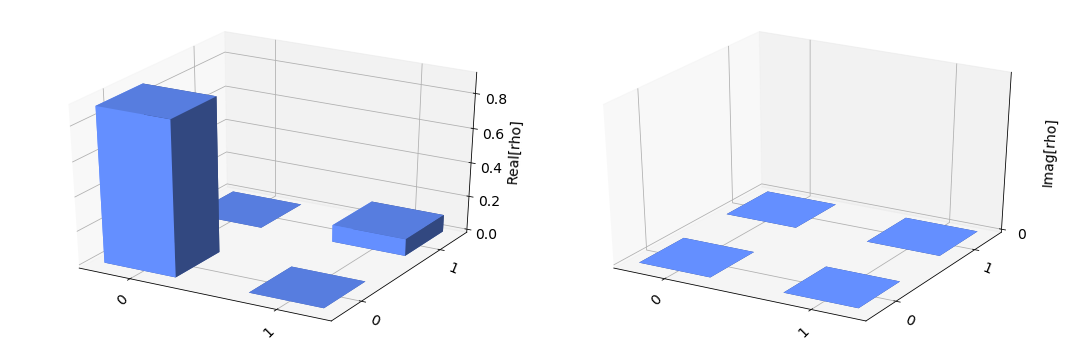

In [15]:
qplt.plot_state_city(rho)

## Noisy Quantum Gates

Noisy quantum gates (CPTP-maps) a *roughly speaking* operations which map density matrices to density matrices. Thus, like density matrices themselves they represent our *average knowledge* about evolution of a system (under certain assumptions).

They may always be written in the **Kraus representation** as

$$\mathcal{E}(\rho) = \sum_j K_j \rho K_j^\dagger, \quad\mbox{where}\quad \sum_j K_j^\dagger K_j = \mathbb{1}$$

The set of matrices $\{K_j\}$ *non-uniquely* defines a noisy quantum gate.

A *unique* representation of a CPTP map is the linear *superoperator* $S$, which is the matrix that acts on *vectorized* density matrices:

$$|\mathcal{E}\rangle\!\rangle = S|\rho\rangle\!\rangle$$

In terms of the *Kraus* representation the superoprator is given by $S = \sum_j K_j^*\otimes K_j$ and is a $4^n * 4^n$ matrix.

### Example: Noisy X gate

* Suppose we have a device that is supposed to apply an $X$ gate to a qubit.
* 10% of the time it does nothing (an identity gate)
* We describe the *average output* of this noisy process on an *arbitrary* state as the CPTP map:

$$\mathcal{E}(\rho) = \frac{9}{10}\, X\rho X + \frac{1}{10}\, \rho$$

* In terms of a Kraus representation this is $\{\sqrt{9/10}\, X, \sqrt{1/10}\, I\}$
* **NOTE:** This is a special case of a CPTP map called a *mixed unitary channel*, where all the Kraus operators are a unitary matrix applied with some probability

### How do we apply CPTP maps in simulation?

* If we want to do a density matrix simulation we require $16 * 4^n$ complex floating point numbers to store the state itself
* We require an additional $16 * 16^m$ complex floats for each $m$-qubit superoperator to apply.
* This greatly limits the size of systems we can simulate

### Alternative approach: quantum trajectories

* We can mimic CPTP evolution by *unravelling* noisy gates into (possibly non-unitary) operations that can be applied to a pure quantum state
* We must rescale the statevector after such a gate to preserve normalization
* We recover the average dynamics of the map by *averaging* over the output of many shots
* **NOTE:** This trades of memory requirement for simulation time (less RAM more shots)

### Quantum Trajectory state update

* Let the system be in the pure state $|psi\rangle$
* Consider a Kraus gate error $\{K_j\}$
* Compute probability of applying Kraus operator $j$ to the state from:
$$ p_j = |\langle\psi|K_j^\dagger K_j\psi\rangle|^2 $$
* Sample a single Kraus operator to apply from the discrete distribution give by $\{p_j\}$
* Update the state to:
$$|\psi^\prime\rangle = \frac{1}{\sqrt{p_j}} K_j|\psi\rangle$$

### Important: Mixed unitary errors

* This can be done more efficiently for mixed unitary error channels
* *The probabilities are known ahead of time and are independent of the current state*
* In this case for each noisy operation we can sample the noisy unitary to apply in advance and insert it into the circuit. Then apply the noisy circuits to the initial state and average over the output

## Noisy Measurement

* Noisy measurement is represented by a POVM $\{E_j\}$, where $E_j \ge 0$, $\sum_j E_j = \mathbb{1}$.

* Measurement outcome probability is given by $p_j = Tr[E_j\rho]$.

* For simulation purposes we consider *two types* of noisy measurement.
 
  1. **Quantum measurement error:** The error can be expressed as a CPTP map *before* an ideal measurement.
  2. **Classical readout error:** The error is expressed as a stochastic map that applies to the *classical register* recording the measurement outcome *after measurment*.

### Classical Readout Error

* Readout errors are specified by a list of assignment probabilities vectors $P(A|B)$.
  * $A$ is the *recorded* classical bit value
  * $B$ is the *true* bit value returned from the measurement 
 
Eg for 1 qubits: $ P(A|B) = [P(A|0), P(A|1)]$


# Noisy Simulations with Qiskit Aer

* We will demonstrate how noisy simulations may be done in Qiskit-Aer
* The `QasmSimulator` supports a trajector based noise simulation

## Qiskit Aer Noise Module

* The `aer.noise` module contains Python classes to build customized noise models for simulation.
* Three key classes:

  1. The `NoiseModel` class which stores a noise model used for noisy simulation 
  2. The `QuantumError` class which describes CPTP gate errors. These can be applied
    * After *gate* or *reset* instructions
    * Before *measure* instructions.
  3. The `ReadoutError` class which describes classical readout errors.
* Functions to generate common `QuantumError` objects in `aer.noise.errors`.
* Functions to automatically generate a noise model in `aer.noise.device`


### Importing necessary functions

In [16]:
# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

# Import noise base clases
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
from qiskit.providers.aer.noise.errors.readout_error import ReadoutError

## Standard Quantum Errors

Rather than deal with the `QuantumError` object directly, many helper functions exist to automatically generate a specific type of parameterized quantum error. These are contained in the `noise.errors` submodule and include functions for many common errors types used in quantum computing research. The function names and the type of error they return are:

| Standard error function | Details |
| --- | --- |
| `kraus_error` | a general n-qubit CPTP error channel given as a list of Kraus matrices $[K_0, ...]$. |
| `mixed_unitary_error` | an n-qubit mixed unitary error given as a list of unitary matrices and probabilities $[(U_0, p_0),...]$. |
| `coherent_unitary_error` | an n-qubit coherent unitary error given as a single unitary matrix $U$. |
| `pauli_error` | an n-qubit Pauli error channel (mixed unitary) given as a list of Pauli's and probabilities $[(P_0, p_0),...]$ |
| `depolarizing_error` | an n-qubit depolarizing error channel parameterized by a depolarizion probability $p$. |
| `reset_error` | a single-qubit reset error parameterized by a probabilities $p_0, p_1$ of reseting to the $|0\rangle$, $|1\rangle$ state.|
| `thermal_relaxation_error` | a single qubit thermal relaxation channel parameterized by relaxation time constants $T_1$, $T_2$, gate time $t$, and excited state thermal population $p_1$. |
| `phase_amplitude_damping_error` | A single-qubit generalized combined phase and amplitude damping error channel given by an amplitude damping parameter $\lambda$, a phase damping parameter $\gamma$, and an excited state thermal population $p_1$. |
| `amplitude_damping_error` |  A single-qubit generalized amplitude damping error channel given by an amplitude damping parameter $\lambda$, and an excited state thermal population $p_1$. |
| `phase_damping_error` |  A single-qubit phase damping error channel given by a phase damping parameter $\gamma$ |

### Combinging Errors

`QuantumError` instances can be combined to produce new Quantum Errors using:
 * Composition: $\cal{E}=\cal{E_1}\circ\cal{E_2}$ as `error1.compose(error2)`
 * Tensor product: $\cal{E}=\cal{E_1}\otimes\cal{E_2}$ as `error1.kron(error2)`

### Example: Depolarizing errors

For example to construct a 5% single-qubit depolarizing error:

In [17]:
# Construct a 1-qubit depolarizing error
depol1 = depolarizing_error(0.05, 1)
print(depol1)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0125, QobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.0125, QobjInstructions = [[{'name': 'y', 'qubits': [0]}]
  P(2) = 0.0125, QobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9625, QobjInstructions = [[{'name': 'id', 'qubits': [0]}]


### Composition

In [18]:
depol1sq = depol1.compose(depol1)
print(depol1sq)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.00015625000000000003, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [0]}]
  P(1) = 0.00015625000000000003, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'y', 'qubits': [0]}]
  P(2) = 0.00015625000000000003, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(3) = 0.01203125, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'id', 'qubits': [0]}]
  P(4) = 0.00015625000000000003, QobjInstructions = [[{'name': 'y', 'qubits': [0]}, {'name': 'x', 'qubits': [0]}]
  P(5) = 0.00015625000000000003, QobjInstructions = [[{'name': 'y', 'qubits': [0]}, {'name': 'y', 'qubits': [0]}]
  P(6) = 0.00015625000000000003, QobjInstructions = [[{'name': 'y', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}]
  P(7) = 0.01203125, QobjInstructions = [[{'name': 'y', 'qubits': [0]}, {'name': 'id', 'qubits': [0]}]
  P(8) = 0.00015625000000000003, QobjInstructions = [[{'name': 'z', 

### Tensor Product

In [19]:
depol2 = depol1.kron(depol1)
print(depol2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.00015625000000000003, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(1) = 0.00015625000000000003, QobjInstructions = [[{'name': 'y', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(2) = 0.00015625000000000003, QobjInstructions = [[{'name': 'z', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(3) = 0.01203125, QobjInstructions = [[{'name': 'id', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(4) = 0.00015625000000000003, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}]
  P(5) = 0.00015625000000000003, QobjInstructions = [[{'name': 'y', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}]
  P(6) = 0.00015625000000000003, QobjInstructions = [[{'name': 'z', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}]
  P(7) = 0.01203125, QobjInstructions = [[{'name': 'id', 'qubits': [0]}, {'name': 'y', 'qubits': [1]}]
  P(8) = 0.00015625000000000003, QobjInstructions = [[{'name': 'x', 

## Adding errors to a Noise Model

When adding a quantum error to a noise model we must specify the type of *instruction* that it acts on, and what qubits to apply it to. There are three cases for Quantum Errors:
 
 1. All-qubit quantum error
 2. Specific qubit quantum error
 3. Non-local quantum error
 
### All-qubit quantum error

This applies the same error to any occurence of an instruciton, regardless of which qubits it acts on.

It is added as `noise_model.add_all_qubit_quantum_error(error, instructions)`:

In [20]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
noise_model.add_all_qubit_quantum_error(depol1, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Instructions with noise: ['u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


### Specific qubit quantum error

This applies the error to any occurence of an instruction acting on a specified list of qubits. Note that the order of the qubit matters: For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0] for example.

It is added as `noise_model.add_quantum_error(error, instructions, qubits)`:

In [21]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
noise_model.add_quantum_error(depol1, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Instructions with noise: ['u3', 'u2', 'u1']
  Specific qubit errors: [('u1', [0]), ('u2', [0]), ('u3', [0])]


### Non-local qubit quantum error

This applies an error to a specific set of noise qubits after any occurence of an instruction acting on a specific of gate qubits.

It is added as `noise_model.add_quantum_error(error, instructions, instr_qubits, error_qubits)`:

In [22]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error on qubit 2 forall single qubit u1, u2, u3 gates on qubit 0 
noise_model.add_nonlocal_quantum_error(depol1, ['u1', 'u2', 'u3'], [0], [2])

# Print noise model info
print(noise_model)

NoiseModel:
  Instructions with noise: ['u3', 'u2', 'u1']
  Non-local specific qubit errors: [('u1', [0], [2]), ('u2', [0], [2]), ('u3', [0], [2])]


### Executing a noisy simulation with a noise model

* To execute a noisy simulation we pass the noise model object to `QasmSimulator.run` or `execute` using the `noise_model` kwarg.
* Eg: `qiskit.execute(circuits, QasmSimulator(), noise_model=noise)`

**Important:** *When running a noisy simulation make sure you compile your qobj to the same basis gates as the noise model!*

This can be done using `NoiseModel.basis_gates`

# Noise Model Examples

We will now give some examples of noise models

### Test circuit

* For our demonstrations we wil use a simple test circuit generating a n-qubit GHZ state:

In [23]:
# Simulator
simulator = QasmSimulator()

# System Specification
n_qubits = 4
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
circ = QuantumCircuit(qr, cr)

# Test Circuit
circ.h(qr[0])
for qubit in range(n_qubits - 1):
    circ.cx(qr[qubit], qr[qubit + 1])
circ.measure(qr, cr)
print(circ.draw())

         ┌───┐     ┌─┐                   
q1_0: |0>┤ H ├──■──┤M├───────────────────
         └───┘┌─┴─┐└╥┘     ┌─┐           
q1_1: |0>─────┤ X ├─╫───■──┤M├───────────
              └───┘ ║ ┌─┴─┐└╥┘        ┌─┐
q1_2: |0>───────────╫─┤ X ├─╫───■─────┤M├
                    ║ └───┘ ║ ┌─┴─┐┌─┐└╥┘
q1_3: |0>───────────╫───────╫─┤ X ├┤M├─╫─
                    ║       ║ └───┘└╥┘ ║ 
 c0_0: 0 ═══════════╩═══════╬═══════╬══╬═
                            ║       ║  ║ 
 c0_1: 0 ═══════════════════╩═══════╬══╬═
                                    ║  ║ 
 c0_2: 0 ═══════════════════════════╬══╩═
                                    ║    
 c0_3: 0 ═══════════════════════════╩════
                                         


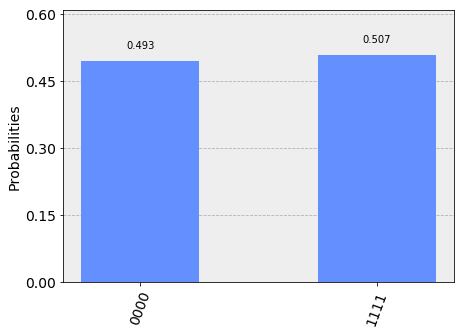

In [24]:
# Test execution
result = qiskit.execute(circ, simulator).result()
qplt.plot_histogram(result.get_counts(0))

# Basic Error Model Examples

## Example 1: Basic bit-flip error noise model

Lets consider a simple toy noise model example common in quantum information theory research:

* When applying a single qubit gate, flip the state of the qubit with probability `p_gate1.
* When applying a 2-qubit gate apply single-qubit errors to each qubit.
* When reseting a qubit reset to 1 instead of 0 with probability `p_reset`
* When measuring a qubit, flip the state of the qubit before with probability `p_meas`.

In [25]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.kron(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Instructions with noise: ['cx', 'u1', 'u3', 'u2', 'measure', 'reset']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Executing the noisy simulation

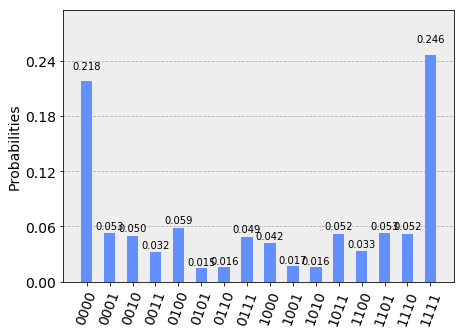

In [26]:
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ, simulator,
               basis_gates=noise_bit_flip.basis_gates)

# Run the noisy simulation
result_bit_flip = simulator.run(qobj, noise_model=noise_bit_flip).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
qplt.plot_histogram(counts_bit_flip)

## Example 2: T1/T2 thermal relaxation

* Now consider a more realistic error model based on thermal relaxation with the qubit environment
* Each qubit parameterized by a thermal relaxation time constant $T_1$ and a dephasing time constant $T_2$.
* Note that we must have $T_2 \le 2 T_1$
* Error rates on instructions are determined by gate time and qubit $T_1$, $T_2$ values

In [27]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).kron(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Instructions with noise: ['cx', 'u3', 'u2', 'measure', 'reset']
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


### Executing the noisy simulation

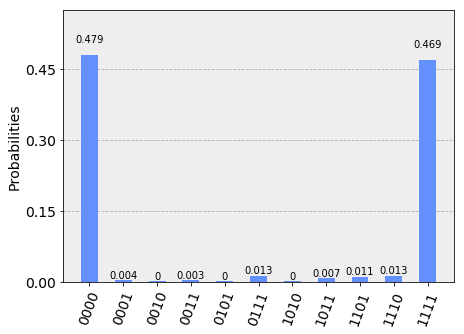

In [28]:
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ, simulator,
                      basis_gates=noise_thermal.basis_gates)

# Run the noisy simulation
result_thermal = simulator.run(qobj, noise_model=noise_thermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
qplt.plot_histogram(counts_thermal)

# Intermediate Error Model Examples

We will now show how one can simulate more complicated error processes using the Qiskit-Aer noise model

## Example 3: Correlated spectator qubit noise

* For our second example we will consider correlated spectator qubit noise on the CX gates in our test circuit.

* Let us consider the case where our 4 qubits are arrange on the verticies of a square.
* Apply a CNOT gate with control $c$ and target $t$.
* With probability $p$ there is a of a correlated $ZZ$ error between $t$ and spectator qubit $s$ coupled to the control:

```
c -- t                     I -- I              I -- Z
|    |  --> (1-p) * CNOT * |    | + p * CNOT * |    |
s -- x                     I -- I              Z -- I
```

In [29]:
# Define an example coupling map for the square
coupling_map = [[0, 1], [0, 3], [2, 1], [2, 3]]

# Example error probabilities
p_01 = 0.03
p_03 = 0.01
p_21 = 0.02
p_23 = 0.05

# QuantumError objects
def zz_error(p):
    return pauli_error([('ZZ', p), ('II', 1 - p)])

# Add errors to noise model
noise_corr_cx = NoiseModel()
noise_corr_cx.add_nonlocal_quantum_error(zz_error(p_01), "cx", [0, 1], [1, 3])
noise_corr_cx.add_nonlocal_quantum_error(zz_error(p_01), "cx", [0, 3], [1, 3])
noise_corr_cx.add_nonlocal_quantum_error(zz_error(p_01), "cx", [2, 1], [1, 3])
noise_corr_cx.add_nonlocal_quantum_error(zz_error(p_01), "cx", [2, 3], [1, 3])

print(noise_corr_cx)

NoiseModel:
  Instructions with noise: ['cx']
  Non-local specific qubit errors: [('cx', [0, 1], [1, 3]), ('cx', [0, 3], [1, 3]), ('cx', [2, 1], [1, 3]), ('cx', [2, 3], [1, 3])]


### Executing the noisy simulation

Now when we execute we have to remember to compile using the coupling map so that the CX gates of the circuit will be mapped to those in the coupling map that are specified in the noise model

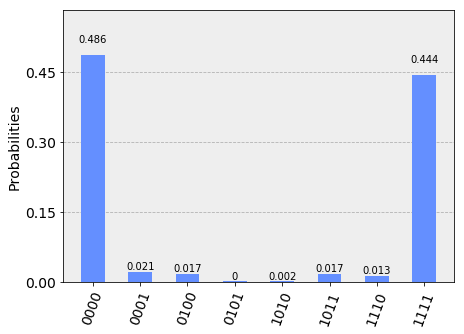

In [30]:
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ, simulator,
                      coupling_map=coupling_map,
                      basis_gates=noise_corr_cx.basis_gates)

# Run the noisy simulation
result_corr_cx = simulator.run(qobj, noise_model=noise_corr_cx).result()
counts_corr_cx = result_corr_cx.get_counts(0)

# Plot noisy output
qplt.plot_histogram(counts_corr_cx)

## Example 4: Coherent leakage error

* *Leakage* is an error that occurs when a qubit is actually a subspace in a higher-dimensional system
* Coherent leakage errors are unitary errors between the qubit subspace and the other energy levels.
* Now show how one can model *leakage error* even though the simulation is only a qubit simulation. 

### To model coherent leakage:

* We add a second quantum register of ancilla qubits to represent the leakage levels for each original qubit
* We add  second set of classical bits to flag when leakage has occured based on the state of the ancilla qubits
* For a single qubit we have 
$$|\psi\rangle \mapsto  |\phi\rangle\otimes|\psi\rangle$$ 


* where our qubit is now a four level system

$$
\begin{align}
|0\rangle \equiv |0\rangle\otimes|0\rangle \\
|1\rangle \equiv |0\rangle\otimes|1\rangle \\
|2\rangle \equiv |1\rangle\otimes|0\rangle \\
|3\rangle \equiv |1\rangle\otimes|1\rangle
\end{align}
$$

* If we measure the ancilla qubit state $|\phi\rangle$ and get an outcome of 1 we know that the qubit state is in the leakage subspace.

In [31]:
# Define additional registers
qa = QuantumRegister(n_qubits)
ca = ClassicalRegister(n_qubits)
circ_leakage = QuantumCircuit(qr, qa, cr, ca)

# Add original circuit
circ_leakage += circ

# Measure ancillas to flag leakage
circ_leakage.barrier(qr, qa)
circ_leakage.measure(qa, ca)
print(circ_leakage)

         ┌───┐               ┌─┐          ░             
q1_0: |0>┤ H ├──■────────────┤M├──────────░─────────────
         └───┘┌─┴─┐          └╥┘┌─┐       ░             
q1_1: |0>─────┤ X ├──■────────╫─┤M├───────░─────────────
              └───┘┌─┴─┐      ║ └╥┘┌─┐    ░             
q1_2: |0>──────────┤ X ├──■───╫──╫─┤M├────░─────────────
                   └───┘┌─┴─┐ ║  ║ └╥┘┌─┐ ░             
q1_3: |0>───────────────┤ X ├─╫──╫──╫─┤M├─░─────────────
                        └───┘ ║  ║  ║ └╥┘ ░ ┌─┐         
q2_0: |0>─────────────────────╫──╫──╫──╫──░─┤M├─────────
                              ║  ║  ║  ║  ░ └╥┘┌─┐      
q2_1: |0>─────────────────────╫──╫──╫──╫──░──╫─┤M├──────
                              ║  ║  ║  ║  ░  ║ └╥┘┌─┐   
q2_2: |0>─────────────────────╫──╫──╫──╫──░──╫──╫─┤M├───
                              ║  ║  ║  ║  ░  ║  ║ └╥┘┌─┐
q2_3: |0>─────────────────────╫──╫──╫──╫──░──╫──╫──╫─┤M├
                              ║  ║  ║  ║  ░  ║  ║  ║ └╥┘
 c0_0: 0 ═════════════════════╩

### Representing coherent leakage error

* Represent a coherent leakage error as a 2-qubit unitary matrix.
* Add it to the noise model as a non-local error for gates on the gate qubit
* Non-local error  effects both the gate qubit and corresponding ancilla qubit

In [32]:
from scipy.linalg import expm

# Ideal X-90 drive Hamiltonian
H_ideal =  0.25 * np.pi * np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
U_ideal = U_noisy = expm(-1j * H_ideal)

# Coherent unitary error due to leakage transitions in Hamiltonian
H_error = 0.1 * np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]])
U_error = coherent_unitary_error(np.dot(U_ideal.conj().T, expm(-1j * (H_ideal + H_error))))

# Build noise model and add to H and CX
# For CX we will just do a tensor-product of the single qubit errors
U_error2 = U_error.kron(U_error)

# Add errors to noise model, but be careful about qubit numbers!
noise_leakage = NoiseModel()
for i in range(n_qubits):
    noise_leakage.add_nonlocal_quantum_error(U_error, ['u1', 'u2', 'u3'],
                                             [i], [i, n_qubits + i])
    for j in range(n_qubits):
        if j != i:
            noise_leakage.add_nonlocal_quantum_error(U_error2, 'cx',
                                                     [i, j],
                                                     [i, n_qubits + i, j, n_qubits + j])
print(noise_leakage)

NoiseModel:
  Instructions with noise: ['u2', 'cx', 'u3', 'u1']
  Non-local specific qubit errors: [('u1', [0], [0, 4]), ('u1', [1], [1, 5]), ('u1', [2], [2, 6]), ('u1', [3], [3, 7]), ('u2', [0], [0, 4]), ('u2', [1], [1, 5]), ('u2', [2], [2, 6]), ('u2', [3], [3, 7]), ('u3', [0], [0, 4]), ('u3', [1], [1, 5]), ('u3', [2], [2, 6]), ('u3', [3], [3, 7]), ('cx', [0, 1], [0, 4, 1, 5]), ('cx', [0, 2], [0, 4, 2, 6]), ('cx', [0, 3], [0, 4, 3, 7]), ('cx', [1, 0], [1, 5, 0, 4]), ('cx', [1, 2], [1, 5, 2, 6]), ('cx', [1, 3], [1, 5, 3, 7]), ('cx', [2, 0], [2, 6, 0, 4]), ('cx', [2, 1], [2, 6, 1, 5]), ('cx', [2, 3], [2, 6, 3, 7]), ('cx', [3, 0], [3, 7, 0, 4]), ('cx', [3, 1], [3, 7, 1, 5]), ('cx', [3, 2], [3, 7, 2, 6])]


### Executing the noisy simulation

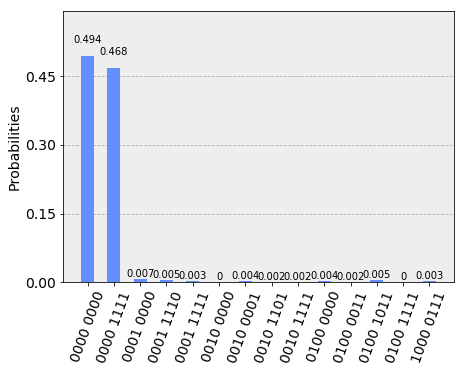

In [33]:
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ_leakage, simulator,
                      basis_gates=noise_leakage.basis_gates)

result_leakage = simulator.run(qobj, noise_model=noise_leakage).result()
counts_leakage = result_leakage.get_counts(0)

# Plot noisy output
qplt.plot_histogram(counts_leakage)

# Advanced Noise Model Examples

These advanced noise modules use features of *Qiskit Aer* that aren't fully integrated with Qiskit Terra. They involve modifying a compiled qobj to insert special instructions that will be added to the Terra QuantumCircuit API in a future release.

## Example 5: Adding correlated classical readout error

* Now let us consider adding a correlated readout error on a multi-qubit measurement. 

* For 2-qubits our assignment probabilities are
$$P(A|B) = [P(A|00), P(A|01), P(A|10), P(A|11)]$$

* We will build the noise model for 2-qubit readout errors on pairs of qubits `[0, 1]` and `[2, 3]` 
* *Note: We could also do a 4-qubit correlated readout error, but we'll stick to 2-qubit to keep the matrices small*

In [34]:
# Assignment probabilities for measure qubits [0, 1]
p_00_qubits01 = [0.8, 0.1, 0.1, 0.0]
p_01_qubits01 = [0.2, 0.6, 0.1, 0.1]
p_10_qubits01 = [0.2, 0.1, 0.6, 0.1]
p_11_qubits01 = [0.1, 0.2, 0.2, 0.5]
p_qubits01 = [p_00_qubits01, p_01_qubits01, p_10_qubits01, p_11_qubits01]

# Assignment probabilities for measure qubits [2, 3]
p_00_qubits23 = [0.7, 0.1, 0.1, 0.1]
p_01_qubits23 = [0.2, 0.6, 0.1, 0.1]
p_10_qubits23 = [0.2, 0.1, 0.6, 0.1]
p_11_qubits23 = [0.2, 0.2, 0.2, 0.4]
p_qubits23 = [p_00_qubits23, p_01_qubits23, p_10_qubits23, p_11_qubits23]

# Build readout error objects
ro_error01 = ReadoutError(p_qubits01)
print(ro_error01)

# Build readout error objects
ro_error23 = ReadoutError(p_qubits23)
print(ro_error23)

ReadoutError on 2 qubits. Assignment probabilities:
 P(j|0) =  [0.8, 0.1, 0.1, 0.0]
 P(j|1) =  [0.2, 0.6, 0.1, 0.1]
 P(j|2) =  [0.2, 0.1, 0.6, 0.1]
 P(j|3) =  [0.1, 0.2, 0.2, 0.5]
ReadoutError on 2 qubits. Assignment probabilities:
 P(j|0) =  [0.7, 0.1, 0.1, 0.1]
 P(j|1) =  [0.2, 0.6, 0.1, 0.1]
 P(j|2) =  [0.2, 0.1, 0.6, 0.1]
 P(j|3) =  [0.2, 0.2, 0.2, 0.4]


Now we add these errors to the noise model, note that we dont actually have to construct the `ReadoutError` object, we could just add the readout errors using the lists of probabilities `p_qubitsij` directly 

In [35]:
noise_corr_ro = NoiseModel()
noise_corr_ro.add_readout_error(ro_error01, [0, 1])
noise_corr_ro.add_readout_error(ro_error01, [2, 3])
print(noise_corr_ro)

NoiseModel:
  Instructions with noise: ['measure']
  Specific qubit errors: [('measure', [0, 1]), ('measure', [2, 3])]


### Executing the noisy simulation

* To actually use this model in a simulation we need to modify our qobj
* We need to make the `measure` instruction a multi-qubit measurement
* Editing is necessary as the Terra compiler decomposes all `measure` circuit instructions into successive single-qubit `measure` qobj instructions.
* We can do this using helper functions in `aer.utils.qobj_utils`


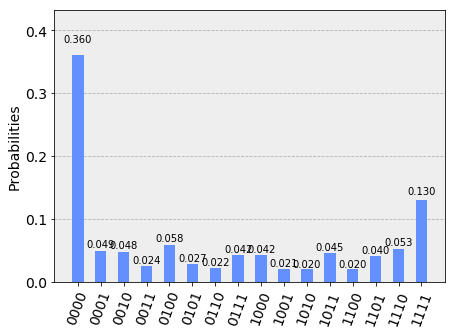

In [36]:
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ, simulator,
                      basis_gates=noise_corr_ro.basis_gates)

# Find measure instruction positions in qobj and drop them
meas_pos = aer.utils.qobj_utils.get_instr_pos(qobj, 0, 'measure')

# Delete measure from qobj
instructions = qobj.experiments[0].instructions
[instructions.pop(j) for j in reversed(meas_pos)]

# Add new multi-qubit measure instructions
meas01 = aer.utils.qobj_utils.measure_instr([0, 1], [0, 1])
meas23 = aer.utils.qobj_utils.measure_instr([2, 3], [2, 3])
instructions += [meas01, meas23]

# Replace experiment instructions with new modified ones
qobj.experiments[0].instructions = instructions

# Run the noisy simulation
result_corr_ro = simulator.run(qobj, noise_model=noise_corr_ro).result()
counts_corr_ro = result_corr_ro.get_counts(0)

# Plot noisy output
qplt.plot_histogram(counts_corr_ro)

## Example 6: Always-on cross-talk noise

Finally we will add always on cross-talk to do this we will define a noise model on a *custom unitary gate* (which in our case will be an identity), that we can then assign an error to in the noise model. We will insert this gate in between all slices to simulate an always on multi-qubit cross-talk error.

Let us consider an error that consists of correlated two-body $XX$ errors between all the qubits on a square

In [37]:
p01 = 0.01
p03 = 0.03
p21 = 0.02
p23 = 0.04
ct_error = pauli_error([('IIXX', p01),
                        ('XIIX', p03),
                        ('IXXI', p21),
                        ('XXII', p23),
                        ('IIII', 1 - p01 - p03 - p21 - p23)],
                        standard_gates=True)
print(ct_error)

# Add error to a noise model for custom instruction "ct"
noise_ct = NoiseModel()
noise_ct.add_nonlocal_quantum_error(ct_error, "ct", [0], [0, 1, 2, 3])
# the following aren't really necessary if we always apply ct to qubit-0
noise_ct.add_nonlocal_quantum_error(ct_error, "ct", [1], [0, 1, 2, 3]) 
noise_ct.add_nonlocal_quantum_error(ct_error, "ct", [2], [0, 1, 2, 3])
noise_ct.add_nonlocal_quantum_error(ct_error, "ct", [3], [0, 1, 2, 3])

print(noise_ct)

QuantumError on 4 qubits. Noise circuits:
  P(0) = 0.01, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [1]}]
  P(1) = 0.03, QobjInstructions = [[{'name': 'x', 'qubits': [0]}, {'name': 'x', 'qubits': [3]}]
  P(2) = 0.02, QobjInstructions = [[{'name': 'x', 'qubits': [1]}, {'name': 'x', 'qubits': [2]}]
  P(3) = 0.04, QobjInstructions = [[{'name': 'x', 'qubits': [2]}, {'name': 'x', 'qubits': [3]}]
  P(4) = 0.8999999999999999, QobjInstructions = [[{'name': 'id', 'qubits': [0]}]
NoiseModel:
  Instructions with noise: ['ct']
  Non-local specific qubit errors: [('ct', [0], [0, 1, 2, 3]), ('ct', [1], [0, 1, 2, 3]), ('ct', [2], [0, 1, 2, 3]), ('ct', [3], [0, 1, 2, 3])]


### Executing noisy simulation

* We need to modify the Qobj for custom gate errors
* First we compile to a qobj
* Next we insert our custom identity matrix with name `"ct"` after the Hadamard and CX gates

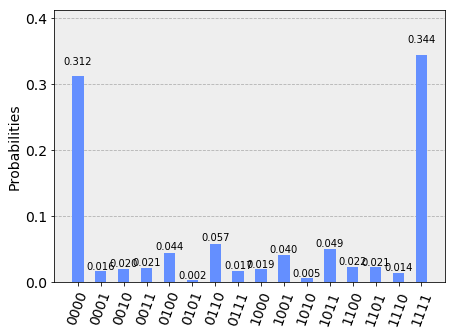

In [38]:
# Compile previous GHZ circuit using noise model basis gates
qobj = qiskit.compile(circ, simulator,
                      basis_gates=noise_ct.basis_gates)

# Create custom gate
ct_gate = aer.utils.qobj_utils.unitary_instr(np.eye(2), [0], label="ct")

# Because of our noise basis gates the circuit will be compiled to U and CX gates:
U_pos = aer.utils.qobj_utils.get_instr_pos(qobj, 0, 'U')
CX_pos = aer.utils.qobj_utils.get_instr_pos(qobj, 0, 'CX')
for pos in reversed(sorted(U_pos + CX_pos)):
    aer.utils.qobj_utils.insert_instr(qobj, 0, ct_gate, pos + 1)

# Run the noisy simulation
result_ct = simulator.run(qobj, noise_model=noise_ct).result()
counts_ct = result_ct.get_counts(0)

# Plot noisy output
qplt.plot_histogram(counts_ct)